In [313]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np

In [623]:
channel = 7

In [624]:
#Tensione per considerare il segnale come saturato
Vt = np.array([-1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.5, -1.3, 
               -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3]) #V
#Carica per filtrare spike ed eventi triggerati male
Q_max = np.array([-30, -30, -30, -30, -30, -30, -30, -30, 
                  -30, -30, -30, -30, -30, -30, -30, -30, ]) #pC
#Carica per filtrare cosmici
Q_min = np.array([-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 
                  -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, ]) #pC

Vt = Vt[channel]
Q_max = Q_max[channel]
Q_min = Q_min[channel]

In [625]:
PATH = '../Dati/21-03/Run_ch' + str(channel) + '_Cs_Measurements_Only_3_21_2024_0000.root' #Percorso relativo del file da analizzare
RunCs = uproot.open(PATH) #Apertura file da analizzare

noise_file = '../Dati/21-03/Run_ch' + str(channel) + '_X_Measurements_Only_3_21_2024_0000.root'  #File di rumore di riferimento per il canale
RunNoise = uproot.open(noise_file)  #Apertura rumore

In [626]:
#Estrazione dati da file 

chargeCs = np.array(RunCs['tree'].arrays()['charge'])
ampCs = np.array(RunCs['tree'].arrays()['amp'])

chargeN = np.array(RunNoise['tree'].arrays()['charge'])
ampN = np.array(RunNoise['tree'].arrays()['amp'])

evCsT = np.array(RunCs['tree'].arrays()['ev'])[-1]
evNT = np.array(RunNoise['tree'].arrays()['ev'])[-1]

In [627]:
trueCs = ampCs>Vt  #Seleziono solo gli eventi che non saturano
chargeCs = chargeCs[trueCs]
ampCs=ampCs[trueCs]

trueCs = (chargeCs < Q_max) & (chargeCs > Q_min)
chargeCs = chargeCs[trueCs] #Seleziono solo gli eventi con una carica sotto una certa soglia
ampCs=ampCs[trueCs]         #così da trascurare spike ed eventi dovuti a trigger su altro canale


trueX = ampN>Vt             #Procedo allo stesso modo per "ripulire" il rumore
chargeN = chargeN[trueX]
ampN=ampN[trueX]

trueX = (chargeN < Q_max) & (chargeN > Q_min)
chargeN = chargeN[trueX]
ampN=ampN[trueX]

print("#Eventi ripuliti su ch " + str(channel) + " = " + str(len(chargeCs)))
print("#Noise ripulita su ch " + str(channel) + " = " + str(len(chargeN)))

#Eventi ripuliti su ch 7 = 86236
#Noise ripulita su ch 7 = 38506


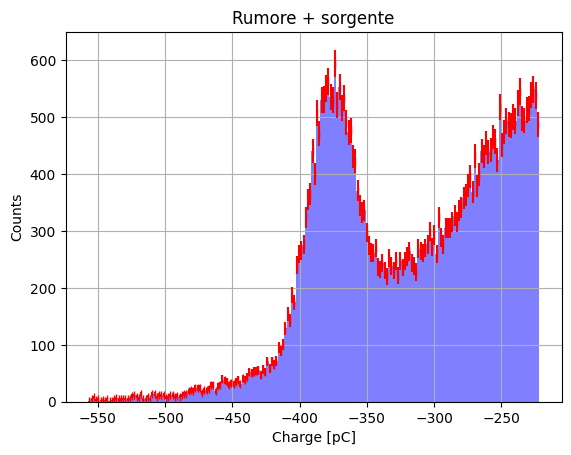

In [639]:
Nbin = 200
bin_lims = [int(Nbin *45 / 100), int(Nbin * 80 / 100)] #Scelgo gli estremi
_, edges, _ = plt.hist(chargeCs, bins = Nbin, color = "r")
plt.clf()
lims = [edges[bin_lims[0]], edges[bin_lims[1]]]
binCs, edgesCs, _ = plt.hist(chargeCs, bins = Nbin, range = lims, color = "b", alpha = 0.5)
centersCs = np.convolve(edgesCs, [0.5, 0.5], "valid")
errCs = np.sqrt(binCs)

plt.errorbar(centersCs, binCs, errCs, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore + sorgente")

plt.show()


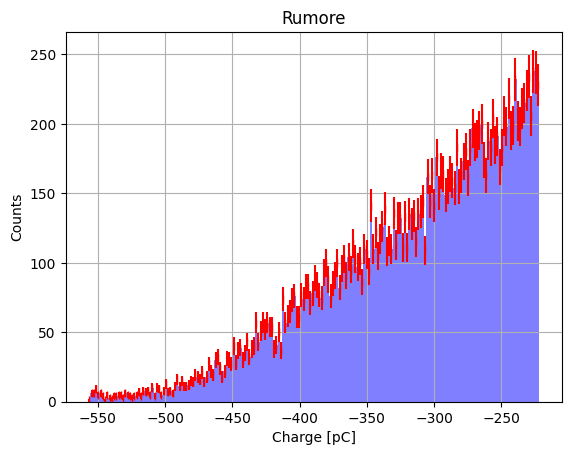

17400.0

In [640]:
binN, edgesN, _ = plt.hist(chargeN, bins = Nbin, range = lims, color = "b", alpha = 0.5)
centersN = np.convolve(edgesN, [0.5, 0.5], "valid")
errN = np.sqrt(binN)
plt.errorbar(centersN, binN, errN, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore")

plt.show()

binN.sum()


In [641]:
from lmfit import minimize, Parameters, Model
from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel #Modelli vari, l'ultimo è Fermi (o Bose)

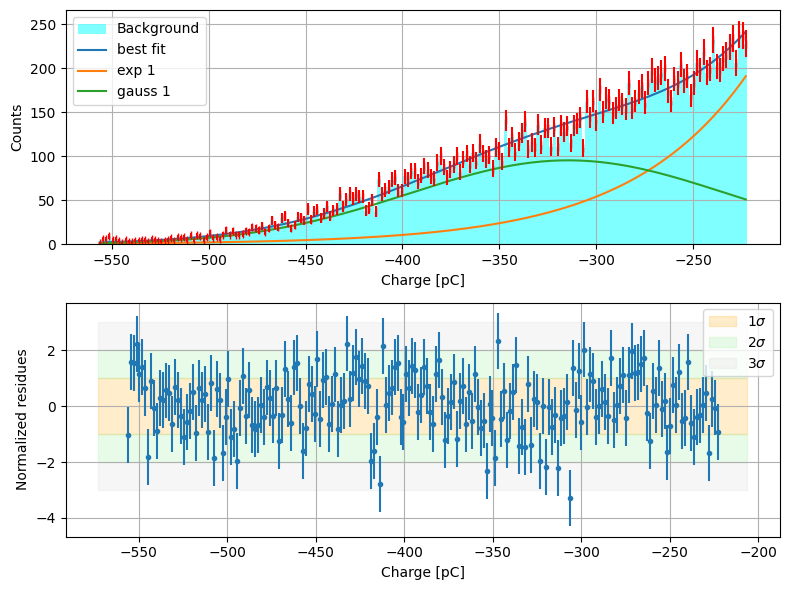

[[Model]]
    ((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 94
    # data points      = 200
    # variables        = 5
    chi-square         = 221.806671
    reduced chi-square = 1.13747011
    Akaike info crit   = 30.6977573
    Bayesian info crit = 47.1893441
    R-squared          = 0.99977439
[[Variables]]
    e1_amplitude:   7278.49965 +/- 4940.20682 (67.87%) (init = 7876.417)
    e1_decay:      -61.1803620 +/- 13.6124257 (22.25%) (init = -76.30226)
    g1_amplitude:   19552.4448 +/- 6182.55542 (31.62%) (init = 44091.44)
    g1_center:     -314.492630 +/- 14.6300881 (4.65%) (init = -277.1736)
    g1_sigma:       81.8393541 +/- 8.35704091 (10.21%) (init = 62.01327)
    g1_fwhm:        192.716945 +/- 19.6793271 (10.21%) == '2.3548200*g1_sigma'
    g1_height:      95.3123041 +/- 20.5762367 (21.59%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2

In [643]:
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
gauss2 = GaussianModel(prefix='g2_')    #Gaussiana
fd1    = ThermalDistributionModel(form = "fermi", prefix = "fd1_") #Fermi Dirac


 
params = exp1.guess(binN, x=centersN)           #Inizializzo i parametri dell'esponenziale
params.update(gauss1.guess(binN, x=centersN))   #Indovina i parametri della prima gaussiana
params.update(gauss2.make_params(amplitude = 0, center = -320, sigma = 25)) #Imposta la seconda gaussiana con A = 0 (necessario per primo fit)
params.update(fd1.make_params(amplitude = 0, center = -200, kt = 0.01))     #Imposta la Fermi Dirac con A = 0 (necessario per primo fit)

params["g2_amplitude"].vary = False    #Blocco i parametri della seconda gaussiana e della 
params["g2_center"].vary = False       #Fermi Dirac: non servono nel primo fit
params["g2_sigma"].vary = False
params["fd1_amplitude"].vary = False
params["fd1_center"].vary = False
params["fd1_kt"].vary = False

model = exp1 + gauss1 + gauss2 #+ fd1     #Per ora non usiamo la Fermi Dirac at all

# Fit the model to the data
result = model.fit(binN, params, x = centersN, weights = 1 / errN, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeN, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersN, result.best_fit, label='best fit')
ax1.plot(centersN, comps['e1_'], label='exp 1')
ax1.plot(centersN, comps['g1_'], label='gauss 1')


ax1.legend()
ax1.errorbar(centersN, binN, errN, color = "red", fmt='|')
ax1.grid()

residueN = binN - result.best_fit
norm_resN = residueN / errN

ax2.errorbar(centersN, norm_resN, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())

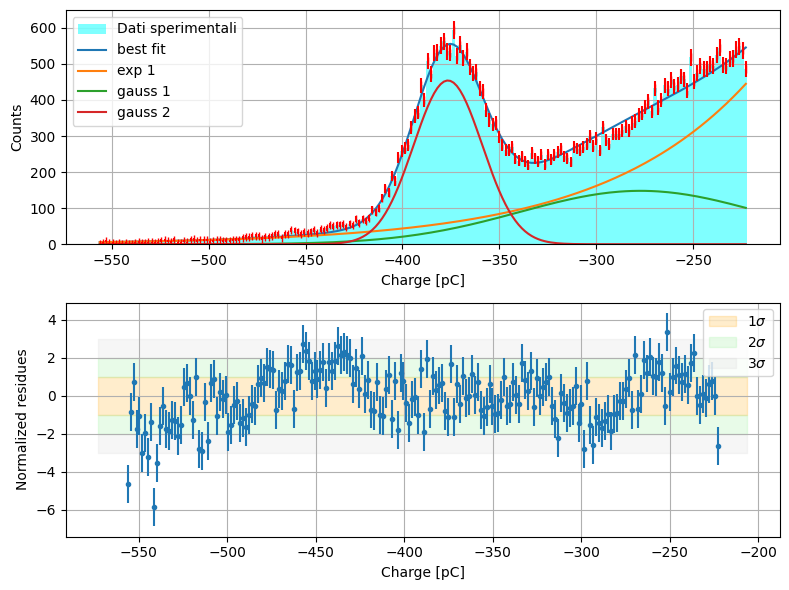

[[Model]]
    ((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 109
    # data points      = 200
    # variables        = 8
    chi-square         = 396.091877
    reduced chi-square = 2.06297853
    Akaike info crit   = 152.665766
    Bayesian info crit = 179.052305
    R-squared          = 0.99994669
##  Warning: uncertainties could not be estimated:
    fd1_amplitude:  at initial value
    fd1_center:     at initial value
    fd1_kt:         at initial value
[[Variables]]
    e1_amplitude:   8238.50258 (init = 7876.417)
    e1_decay:      -76.30226 (fixed)
    g1_amplitude:   23007.4991 (init = 44091.44)
    g1_center:     -277.1736 (fixed)
    g1_sigma:       62.01327 (fixed)
    g1_fwhm:        146.030092 == '2.3548200*g1_sigma'
    g1_height:      148.011295 == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_amplitude:   20120.3350 (init = 1000)
   

In [644]:
params["g1_sigma"].vary = False   #Blocco i parametri dell'esponenziale e della prima gaussiana
params["g1_center"].vary = False  #lasciando libere le ampiezze
params["e1_decay"].vary = False

params["g2_amplitude"].vary = True  #Sblocco i parametri di Fermi Dirac e seconda gaussiana
params["g2_center"].vary = True
params["g2_sigma"].vary = True
params["fd1_amplitude"].vary = True
params["fd1_center"].vary = True
params["fd1_kt"].vary = True


params["g2_amplitude"].value = 1000     #Parametri da aggiustare to make the magic happen
params["g2_center"].min = -400          #Si possono, se serve, specificare canale per canale
params["g2_center"].max = -300
params["g2_center"].set(value = -350)
params["g2_sigma"].set(value = 1)
params["fd1_amplitude"].set(value = 1)


params.update(fd1.guess(binCs, x=centersCs)) #Aggiorno i parametri della seconda gaussiana indovinando

# Fit the model to the data
result = model.fit(binCs, params, x = centersCs, weights = 1 / errCs)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeCs, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Dati sperimentali")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersCs, result.best_fit, label='best fit')
ax1.plot(centersCs, comps['e1_'], label='exp 1')
ax1.plot(centersCs, comps['g1_'], label='gauss 1')
ax1.plot(centersCs, comps['g2_'], label='gauss 2')


ax1.legend()
ax1.errorbar(centersCs, binCs, errCs, color = "red", fmt='|')
ax1.grid()

residueCs = binCs - result.best_fit
norm_resCs = residueCs / errCs

ax2.errorbar(centersCs, norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())

